Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [1]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

In [2]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['Входящий', 'Выходящий']

In [3]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [4]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['03792.jpg', '00555.jpg', '04351.jpg', '01396.jpg', '02494.jpg', '01968.jpg', '05062.jpg', '04015.jpg', '00325.jpg', '01012.jpg', '06231.jpg', '02776.jpg', '04791.jpg', '04871.jpg', '04091.jpg', '05594.jpg', '03171.jpg', '02694.jpg', '05842.jpg', '04910.jpg', '01812.jpg', '00706.jpg', '00397.jpg', '02009.jpg', '05579.jpg', '02234.jpg', '05746.jpg', '03659.jpg', '01547.jpg', '05252.jpg', '02447.jpg', '05966.jpg', '01716.jpg', '00377.jpg', '02347.jpg', '05905.jpg', '03263.jpg', '02862.jpg', '01892.jpg', '02753.jpg', '04819.jpg', '04078.jpg', '06452.jpg', '04859.jpg', '05661.jpg', '03684.jpg', '01268.jpg', '04102.jpg', '04648.jpg', '01963.jpg', '05851.jpg', '01613.jpg', '00081.jpg', '03848.jpg', '02086.jpg', '04971.jpg', '01174.jpg', '03489.jpg', '05707.jpg', '00955.jpg', '05881.jpg', '04487.jpg', '05359.jpg', '01292.jpg', '00940.jpg', '04847.jpg', '01647.jpg', '03850.jpg', '00222.jpg', '01678.jpg', '00335.jpg', '05503.jpg', '04695.jpg', '01116.jpg', '03892.jpg', '05221.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

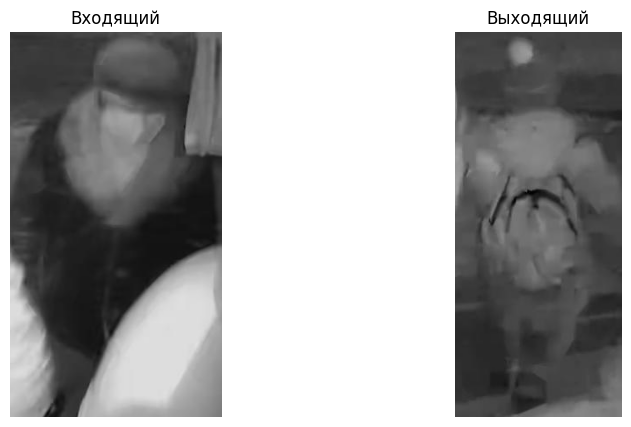

In [5]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [6]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [7]:
print('Пути к файлам: ', data_files[1085:1090])
print('Их метки классов:', data_labels[1085:1090])

Пути к файлам:  ['/content/bus/Входящий/03574.jpg', '/content/bus/Входящий/01106.jpg', '/content/bus/Входящий/00598.jpg', '/content/bus/Входящий/06343.jpg', '/content/bus/Входящий/05639.jpg']
Их метки классов: [0, 0, 0, 0, 0]


In [8]:
# Задание единых размеров изображений
IMG_WIDTH = 64                           # Ширина изображения
IMG_HEIGHT = 128                          # Высота изображения

In [9]:
data_images = []                          # Пустой список для данных изображений

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT))
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(data_labels)            # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 9081 фотографий следующей формы: (128, 64, 3)
Общий массив данных изображений следующей формы: (9081, 128, 64, 3)
Общий массив меток классов следующей формы: (9081,)


array([[[129, 158,  69],
        [112, 146, 103],
        [103, 139, 126],
        ...,
        [ 65,  84,  18],
        [ 83, 107,  20],
        [100, 127,  20]],

       [[ 41, 103, 183],
        [ 24, 110, 221],
        [ 25, 129, 239],
        ...,
        [  0,   6,  55],
        [  2,  12,  40],
        [  8,  20,  36]],

       [[  4, 106, 252],
        [  2, 149, 255],
        [  0, 163, 255],
        ...,
        [  3,   9,  83],
        [  1,   5,  76],
        [  0,   1,  70]],

       ...,

       [[  8,  45,  52],
        [  2,  14,  45],
        [  2,   5,  43],
        ...,
        [ 30, 113, 130],
        [  5,  96, 170],
        [  0,  82, 170]],

       [[ 16,  46,  56],
        [  2,  14,  45],
        [  1,   5,  42],
        ...,
        [ 36, 117, 124],
        [  6,  98, 167],
        [  0,  83, 171]],

       [[ 20,  53,  60],
        [  4,  21,  49],
        [  0,   7,  42],
        ...,
        [ 40, 120, 120],
        [  8,  99, 162],
        [  1,  86, 174]]], dtype=uint8)
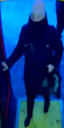

In [10]:
x_data[0]

In [11]:
# Нормированние массива изображений
x_data = x_data / 255.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size= 0.2, shuffle= True, random_state= 42)

In [12]:
# Создание модели последовательной архитектуры
model = Sequential()

# Первый сверточный блок
model.add(Conv2D(256, (3, 3), name='First_C', padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))  # (64,128,3) --> (64,128,256) меняется кол-во фильтров
model.add(BatchNormalization(name='First_B'))

# Второй сверточный блок
model.add(Conv2D(256, (3, 3), name='Second_C', padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), name='Second_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid'

# Третий сверточный блок
model.add(Conv2D(256, (3, 3), name='Third_C', padding='same', activation='relu'))
model.add(BatchNormalization(name='Third_B'))
model.add(Dropout(0.2, name='Third_D'))

# Четвертый сверточный блок
model.add(Conv2D(256, (3, 3), name='Fourth_C', padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), name='Fourth_M'))  # сжимает размер в три раза, потерь нет, т.к. делится нацело
model.add(Dropout(0.2, name='Fourth_D'))

# Пятый сверточный блок
model.add(Conv2D(512, (3, 3), name='Fifth_D', padding='same', activation='relu'))  # меняется количество фильтров
model.add(BatchNormalization(name='Fifth_B'))

# Шестой сверточный блок
model.add(Conv2D(1024, (3, 3), name='Sixth_C', padding='same', activation='relu'))  # меняется кол-во фильтров
model.add(MaxPooling2D(pool_size=(3, 3), name='Sixth_M'))  # сжимает размер в три раза, с потерей
model.add(Dropout(0.2, name='Sixth_D'))

# Блок классификации
model.add(Flatten(name='Class_1'))  # слой преобразования многомерных данных в одномерные
model.add(Dense(2048, activation='relu', name='Class_2'))
model.add(Dense(4096, activation='relu', name='Class_3'))
model.add(Dense(CLASS_COUNT, activation='softmax', name='Class_4'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_C (Conv2D)            (None, 128, 64, 256)      7168      
                                                                 
 First_B (BatchNormalizatio  (None, 128, 64, 256)      1024      
 n)                                                              
                                                                 
 Second_C (Conv2D)           (None, 128, 64, 256)      590080    
                                                                 
 Second_M (MaxPooling2D)     (None, 42, 21, 256)       0         
                                                                 
 Third_C (Conv2D)            (None, 42, 21, 256)       590080    
                                                                 
 Third_B (BatchNormalizatio  (None, 42, 21, 256)       1024      
 n)                                                     

In [14]:
# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [15]:
# Обучение модели сверточной нейронной сети подготовленных данных
history = model.fit(x_train,
                    y_train,
                    validation_split=0.2,
                    shuffle=True,
                    batch_size=25,
                    epochs=35,
                    verbose=1)

Epoch 1/35
291/291 [==============================] - 81s 227ms/step - loss: 0.3449 - accuracy: 0.8944 - val_loss: 2.1626 - val_accuracy: 0.0000e+00
Epoch 2/35
291/291 [==============================] - 57s 195ms/step - loss: 0.2005 - accuracy: 0.9294 - val_loss: 2.9634 - val_accuracy: 0.1112
Epoch 3/35
291/291 [==============================] - 58s 198ms/step - loss: 0.1584 - accuracy: 0.9474 - val_loss: 0.7048 - val_accuracy: 0.6384
Epoch 4/35
291/291 [==============================] - 58s 200ms/step - loss: 0.1172 - accuracy: 0.9594 - val_loss: 0.9900 - val_accuracy: 0.7111
Epoch 5/35
291/291 [==============================] - 57s 195ms/step - loss: 0.0966 - accuracy: 0.9657 - val_loss: 0.6160 - val_accuracy: 0.7182
Epoch 6/35
291/291 [==============================] - 59s 203ms/step - loss: 0.0722 - accuracy: 0.9726 - val_loss: 0.4128 - val_accuracy: 0.8244
Epoch 7/35
291/291 [==============================] - 59s 203ms/step - loss: 0.0502 - accuracy: 0.9838 - val_loss: 0.3841 - va

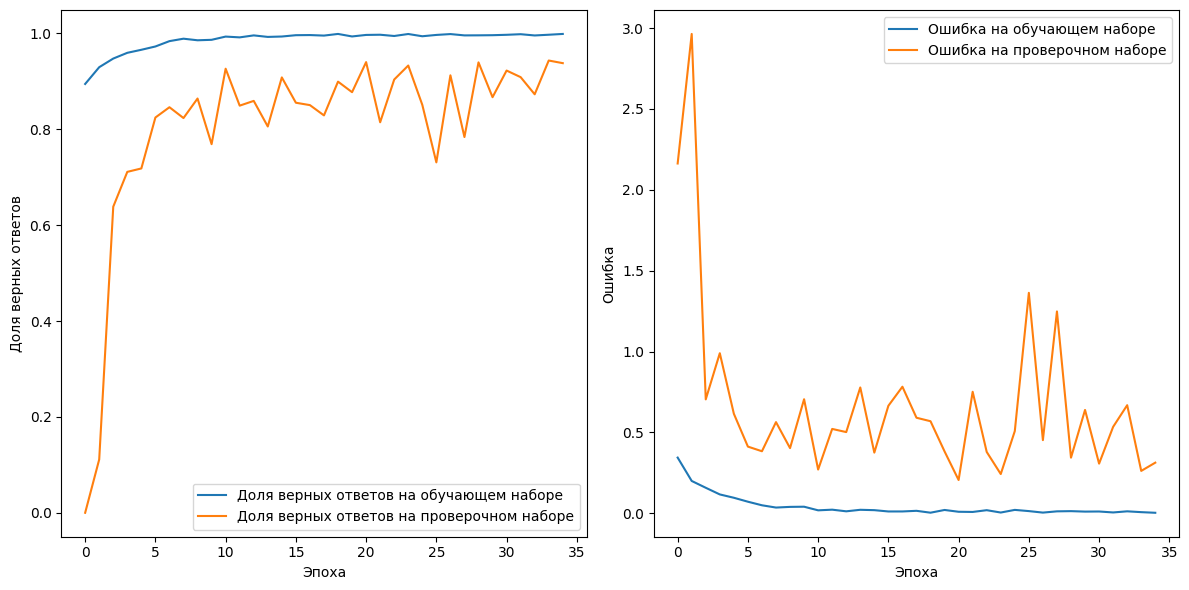

In [17]:
# Создание графика с двумя подграфиками в одной строке
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# График ошибки на обучающем и валидационном наборах данных
axes[0].plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
axes[0].plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Доля верных ответов')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Ошибка на обучающем наборе')
axes[1].plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Ошибка')
axes[1].legend()

#plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [20]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Model 1 - Test Accuracy:", accuracy)

57/57 [==============================] - 6s 47ms/step - loss: 0.0517 - accuracy: 0.9884
Model 1 - Test Accuracy: 0.9884424805641174


## Вывод
Была создана модель НС, точность валидационной и тестовой выборок удовлетворительна